<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts. https://arxiv.org/abs/1710.06071

Dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In [1]:


!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-85d96cba-6568-ff70-6c01-7bf115760082)


#Get data
Copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 11.97 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:

# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start by using the 20k dataset
data_dir="pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [5]:

# Check all of the filenames in the target directory
import os
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

#Preprocess data

In [6]:

# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath.
  Returns:
     A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines=get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def preprocess_text_with_line_numbers(filename):
   """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
   input_lines = get_lines(filename) # get all lines from filename
   abstract_lines = "" # create an empty abstract
   abstract_samples = [] # create an empty list of abstracts
   # Loop through each line in target file
   for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

   return abstract_samples

In [9]:

# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 783 ms, sys: 118 ms, total: 901 ms
Wall time: 1.96 s


(180040, 30212, 30135)

In [10]:

# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:

import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:

# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

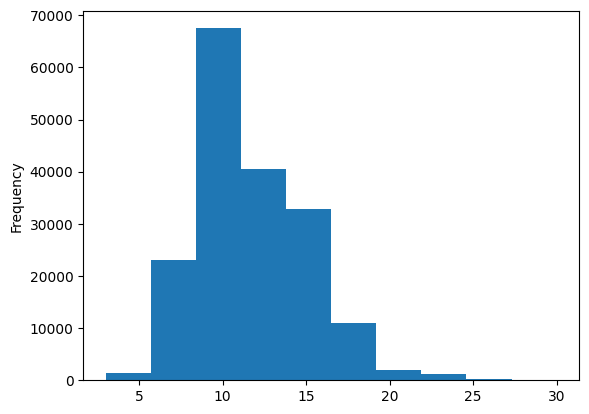

In [13]:

train_df.total_lines.plot.hist();

#Get lists of sentences

In [14]:

# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 30212, 30135)

In [15]:

# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

#Make numeric labels (ML models require numeric labels)

In [16]:
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot_encoded=one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot_encoded=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded=label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded=label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:

# Get class names and number of classes from LabelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

#Model 0: Getting a baseline

In [19]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [20]:
#Evaluate

model_0.score(X=val_sentences,
            y=val_labels_encoded)

0.7218323844829869

In [21]:
#Make predictions
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:

# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-23 09:28:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-23 09:28:10 (82.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results

In [24]:
baseline_results=calculate_results(y_true=val_labels_encoded,
                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

#Preparing our data for deep sequence models

Before start building deeper models create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
#Check sentences lenght
sent_len=[len(sentence.split()) for sentence in train_sentences]
avg_sen_len=np.mean(sent_len)
avg_sen_len


26.338269273494777

In [27]:
max_len=np.max(sent_len)
max_len

296

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

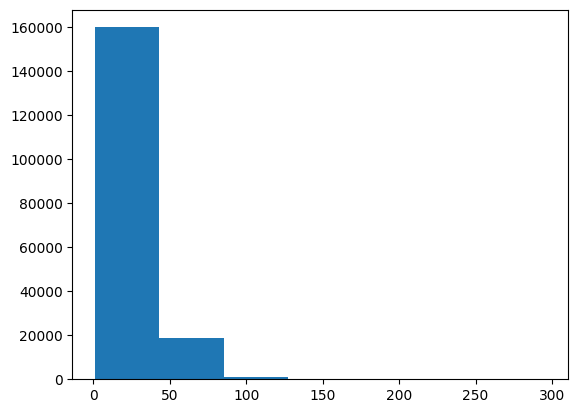

In [28]:
import matplotlib.pyplot as plt
plt.hist(sent_len,bins=7)

In [29]:
#Check the long of a sentance that cover 95% of the lenght
output_seq_len=int(np.percentile(sent_len,95))
output_seq_len

55

#Create text vectorizer

In [30]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [31]:
#create text vectorizer

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [32]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
#test text vectorizer
import random
target_sentence=random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
all mothers were contacted by telephone at six , @ , and @ months and advised to brush their children 's teeth twice daily with low-dose fluoride toothpaste .

Length of text: 29

Vectorized text:
[[  62 1143    9 5582   22 1032   15  356    3   41    3 5462    6 5523
   120  109  130 2059  555  161    7 1127 2527 5043    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [34]:
#How many words in our train vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")


Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
#Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#Create custom text embedding


token_vectorization layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

In [36]:
# Create token embedding layer

token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),  # length of vocabulary
                             output_dim=128,# Note: different embedding sizes result in drastically different numbers of parameters to train
                             mask_zero=True, # Use masking to handle variable sequence lengths (save space)
                             name="token_embedding"
                             )
#Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
all mothers were contacted by telephone at six , @ , and @ months and advised to brush their children 's teeth twice daily with low-dose fluoride toothpaste .

Sentence after vectorization (before embedding):
[[  62 1143    9 5582   22 1032   15  356    3   41    3 5462    6 5523
   120  109  130 2059  555  161    7 1127 2527 5043    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 3.6325660e-02 -3.1563245e-02  7.4766576e-05 ...  1.4393639e-02
    3.0966651e-02 -2.6868522e-02]
  [ 4.1074667e-02 -4.8071265e-02  3.6876503e-02 ...  4.7729563e-02
    7.7469461e-03  3.3411216e-02]
  [ 4.7284786e-02  4.1002009e-02 -1.0612965e-02 ... -3.7641048e-02
   -3.3539940e-02 -4.9052946e-03]
  ...
  [-4.0687479e-02 -2.3921490e-02 -1.0906089e-02 ... -3.8637221e-02
   -3.4953106e-02  4.1559998e-02]
  [-4.0687479e-02 -2.3921490e-02 -1.09

#Create datasets (as fast as possible)

In [37]:
# Turn our data into TensorFlow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot_encoded))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot_encoded))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#Model 1: Conv1D with token embeddings

In [39]:
# Create 1D convolutional model to process sequences
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs) # vectorize text inputs
token_embeddings=token_embed(text_vectors) # create embedding
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(token_embeddings)
x=layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_1=tf.keras.Model(inputs,outputs)

# Compile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [40]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [41]:
#Fit the model
model_1_history=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=val_dataset,
                            validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 22s 32ms/step - loss: 0.9186 - accuracy: 0.6364 - val_loss: 0.6872 - val_accuracy: 0.7407
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6666 - accuracy: 0.7482 - val_loss: 0.6317 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6298 - accuracy: 0.7675 - val_loss: 0.6051 - val_accuracy: 0.7816


In [42]:

# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6128 - accuracy: 0.7803


[0.6128354668617249, 0.7802528738975525]

In [43]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[3.7156236e-01, 1.6873984e-01, 1.5934356e-01, 2.6128575e-01,
        3.9068539e-02],
       [5.0046337e-01, 2.1483050e-01, 9.8419068e-03, 2.6993757e-01,
        4.9266396e-03],
       [1.5727815e-01, 1.5239150e-02, 2.7021887e-03, 8.2473630e-01,
        4.4095297e-05],
       ...,
       [8.2451078e-07, 6.8005611e-04, 9.6697133e-04, 9.0149467e-07,
        9.9835122e-01],
       [6.5751642e-02, 4.9446321e-01, 9.1503851e-02, 8.3476976e-02,
        2.6480430e-01],
       [2.1584646e-01, 5.4861063e-01, 3.3264369e-02, 5.4737411e-02,
        1.4754112e-01]], dtype=float32)

In [44]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [45]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.025287965047,
 'precision': 0.7761003974707331,
 'recall': 0.78025287965047,
 'f1': 0.7775812094127751}

#Model 2: Feature extraction with pretrained token embeddings

To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.
https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true


In [46]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                               trainable=False,
                               name="universal_sentence_encoder")

In [47]:

# Test out the embedding on a random sentence
random_training_sentence=random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
no differences were observed between groups regarding the items assessed ( time required to discharge from study , pulse oximetry in room air and disease severity according to the respiratory distress assessment instrument score ) .

Sentence after embedding:
[-0.00862701 -0.00815303 -0.02588378  0.02150494  0.06036081 -0.05887437
  0.04535963 -0.0299987  -0.03389393  0.05842831  0.08187488  0.04966621
  0.03598568  0.03426059  0.04104401 -0.06746256 -0.06619123  0.0058196
  0.00099395 -0.03477674 -0.02031614  0.03937905 -0.07435979  0.00133905
 -0.07527    -0.01179465 -0.00433344  0.06344198 -0.05309561 -0.06787582] (truncated output)...

Length of sentence embedding:
512


#Building and fitting an NLP feature extraction model from TensorFlow Hub


In [48]:

# Define feature extractor model using TF Hub layer

inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x=layers.Dense(128,activation='relu')(pretrained_embedding) # add a fully connected layer on top of the embedding
outputs=layers.Dense(5,activation='softmax')(x) # create the output layer
model_2=tf.keras.Model(inputs,outputs)

#Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [49]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [50]:
#Fit model 2

model_2.fit(train_dataset,
        steps_per_epoch=int(0.1*len(train_dataset)),
        epochs=3,
        validation_data=val_dataset,
        validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9172 - accuracy: 0.6489 - val_loss: 0.7985 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7703 - accuracy: 0.7008 - val_loss: 0.7576 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7558 - accuracy: 0.7102 - val_loss: 0.7433 - val_accuracy: 0.7131


In [51]:
#Evaluate the model
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7450 - accuracy: 0.7120


[0.7450016736984253, 0.7120349407196045]

In [52]:
#Make predictions
model_2_pred_probs=model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[4.1473782e-01, 3.7657210e-01, 2.2024771e-03, 1.9816761e-01,
        8.3201062e-03],
       [3.5189787e-01, 5.0725025e-01, 2.9562032e-03, 1.3461629e-01,
        3.2793663e-03],
       [2.1253230e-01, 1.4434633e-01, 1.6596021e-02, 5.8965755e-01,
        3.6867779e-02],
       ...,
       [1.5257511e-03, 5.5216667e-03, 5.6606214e-02, 8.5346034e-04,
        9.3549293e-01],
       [3.7484341e-03, 5.0860822e-02, 1.9529802e-01, 1.4707454e-03,
        7.4862200e-01],
       [1.5516947e-01, 2.6298869e-01, 5.1286095e-01, 6.0896627e-03,
        6.2891163e-02]], dtype=float32)

In [53]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [54]:

# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.20349529988084,
 'precision': 0.7124968354955801,
 'recall': 0.7120349529988084,
 'f1': 0.7091479165344508}

#Model 3: Conv1D with character embeddings

In [55]:

# Make function to split sentences into characters
def split_characteers(text):
  return " ".join(list(text))

#Test
split_characteers(random_training_sentence)

'n o   d i f f e r e n c e s   w e r e   o b s e r v e d   b e t w e e n   g r o u p s   r e g a r d i n g   t h e   i t e m s   a s s e s s e d   (   t i m e   r e q u i r e d   t o   d i s c h a r g e   f r o m   s t u d y   ,   p u l s e   o x i m e t r y   i n   r o o m   a i r   a n d   d i s e a s e   s e v e r i t y   a c c o r d i n g   t o   t h e   r e s p i r a t o r y   d i s t r e s s   a s s e s s m e n t   i n s t r u m e n t   s c o r e   )   .'

In [56]:

# Split sequence-level data splits into character-level data splits
train_chars=[split_characteers(sentence) for sentence in train_sentences]
val_chars=[split_characteers(sentence) for sentence in val_sentences]
test_chars=[split_characteers(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [57]:
#Average character lenght
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

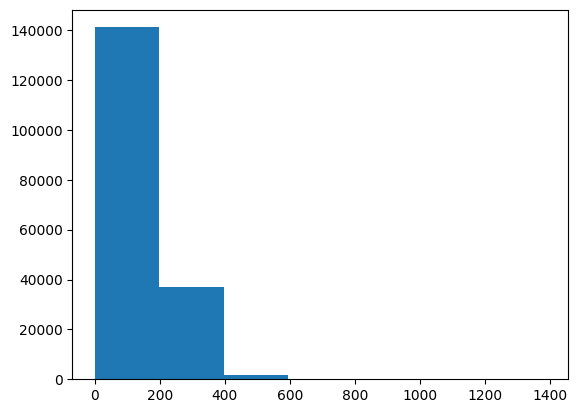

In [58]:
#Distribution of sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [59]:
# Find what character length covers 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [60]:
# Get all keyboard characters for char-level embedding
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [61]:

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS=len(alphabet)+2 # +2 for space and OOV token
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  standardize="lower_and_strip_punctuation",
                                  name="char_vectorizer")
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [62]:
# Check character vocabulary characteristics
char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters in character vocab: {char_vocab[:5]}")
print(f"5 least common characters in character vocab: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters in character vocab: ['', '[UNK]', 'e', 't', 'i']
5 least common characters in character vocab: ['k', 'x', 'z', 'q', 'j']


In [63]:

# Test character vectorizer
random_train_chars=random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars=char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
h i g h   e f f i c i e n c y   o f   p a i n   r e l i e v i n g   f o r   c e r v i c a l   s p o n d y l o s i s   c o u l d   b e   f o u n d   i n   a l l   t h e   @   g r o u p s   ,   w h i c h   s h o w e d   t h a t   s h o r t - t e r m   a n d   l o n g - t e r m   e f f e c t s   w e r e   g o o d   f o r   a l l   t h e   @   g r o u p s   .

Length of random_train_chars: 148

Vectorized chars:
[[13  4 18 13  2 17 17  4 11  4  2  6 11 19  7 17 14  5  4  6  8  2 12  4
   2 21  4  6 18 17  7  8 11  2  8 21  4 11  5 12  9 14  7  6 10 19 12  7
   9  4  9 11  7 16 12 10 22  2 17  7 16  6 10  4  6  5 12 12  3 13  2 18
   8  7 16 14  9 20 13  4 11 13  9 13  7 20  2 10  3 13  5  3  9 13  7  8
   3  3  2  8 15  5  6 10 12  7  6 18  3  2  8 15  2 17 17  2 11  3  9 20
   2  8  2 18  7  7 10 17  7  8  5 12 12  3 13  2 18  8  7 16 14  9  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

#Creating a character-level embedding

In [64]:

# Create char embedding layer
char_embed=layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                            output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                            mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                            name="char_embed")

#Test
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
h i g h   e f f i c i e n c y   o f   p a i n   r e l i e v i n g   f o r   c e r v i c a l   s p o n d y l o s i s   c o u l d   b e   f o u n d   i n   a l l   t h e   @   g r o u p s   ,   w h i c h   s h o w e d   t h a t   s h o r t - t e r m   a n d   l o n g - t e r m   e f f e c t s   w e r e   g o o d   f o r   a l l   t h e   @   g r o u p s   .

Embedded chars (after vectorization and embedding):
[[[-0.01447722 -0.03912499 -0.00463764 ... -0.03243655  0.02767554
   -0.01361144]
  [-0.0324839  -0.03088321 -0.04888587 ...  0.03311879  0.03509678
   -0.0417295 ]
  [ 0.02264916  0.0040194   0.03787995 ... -0.04550647 -0.01169578
   -0.0442609 ]
  ...
  [-0.00662038  0.04261568 -0.03764095 ... -0.03493761  0.00288569
    0.04405824]
  [-0.00662038  0.04261568 -0.03764095 ... -0.03493761  0.00288569
    0.04405824]
  [-0.00662038  0.04261568 -0.03764095 ... -0.03493761  0.00288569
    0.04405824]]]

Character embedding shape: (1

#Building a Conv1D model to fit on character embeddings

In [65]:
# Make Conv1D on chars only
inputs=layers.Input(shape=(1,), dtype="string")
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64, kernel_size=5,padding='same', activation='relu')(char_embeddings)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(num_classes, activation='softmax')(x)
model_3=tf.keras.Model(inputs=inputs, outputs=outputs, name="model_3_conv1d_char_embeddings")

#COmpile model

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [66]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [67]:
# Create char datasets
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [68]:
#Fit the model
model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2627 - accuracy: 0.4932 - val_loss: 1.0486 - val_accuracy: 0.5874
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0077 - accuracy: 0.5985 - val_loss: 0.9459 - val_accuracy: 0.6310
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9340 - accuracy: 0.6302 - val_loss: 0.8761 - val_accuracy: 0.6582


In [69]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8960 - accuracy: 0.6500


[0.8959559202194214, 0.6499735116958618]

In [70]:
#Make predictions
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.1201875 , 0.47458598, 0.1437491 , 0.20659147, 0.05488594],
       [0.12518102, 0.6059964 , 0.00974231, 0.23713201, 0.0219483 ],
       [0.14174281, 0.1422935 , 0.48238692, 0.17353421, 0.0600426 ],
       ...,
       [0.04014158, 0.09038197, 0.19625269, 0.07610144, 0.5971223 ],
       [0.08681787, 0.12076212, 0.42006764, 0.04643114, 0.32592118],
       [0.2854744 , 0.56969863, 0.04276855, 0.09546484, 0.00659363]],
      dtype=float32)

In [71]:
#Convert predictions to classes
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 2, 1])>

In [72]:

# Calculate Conv1D char only model results
model_3_results=calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_3_preds)
model_3_results

{'accuracy': 64.99735204554482,
 'precision': 0.6428885727180278,
 'recall': 0.6499735204554482,
 'f1': 0.6401105390498057}

#Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level model (similar to model_1)

2.Create a character-level model (similar to model_3 with a slight modification to reflect the paper)

3.Combine (using layers.Concatenate) the outputs of 1 and 2

4.Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts

5.Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [73]:
# 1. Setup token inputs/model
token_inputs=layers.Input(shape=[], dtype=tf.string, name="token inputs")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_output=layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model

char_inputs=layers.Input(shape=(1,), dtype=tf.string, name="char inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat=layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf

combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name="model_4_token_and_char_embeddings")

In [74]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

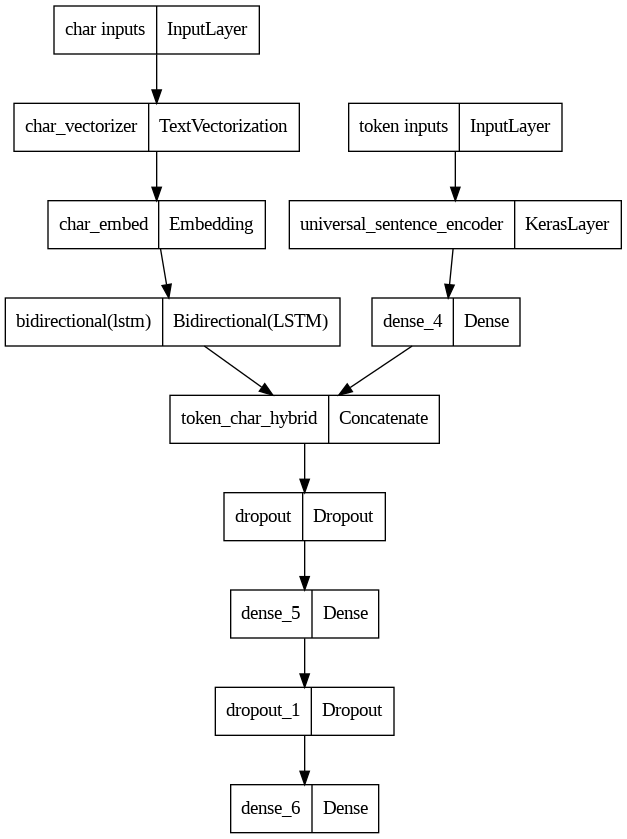

In [75]:
#Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [76]:
#Compile model
model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#Combining token and character data into a tf.data dataset

In [77]:

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot_encoded)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [78]:

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [79]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 29s 41ms/step - loss: 0.9882 - accuracy: 0.6055 - val_loss: 0.7922 - val_accuracy: 0.6948
Epoch 2/3
562/562 [==============================] - 22s 39ms/step - loss: 0.8031 - accuracy: 0.6891 - val_loss: 0.7226 - val_accuracy: 0.7304
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.7751 - accuracy: 0.7025 - val_loss: 0.7058 - val_accuracy: 0.7271


In [80]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.7072 - accuracy: 0.7280


[0.7072473764419556, 0.7279557585716248]

In [81]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs


945/945 [==============================] - 21s 21ms/step


array([[4.5513201e-01, 2.9168314e-01, 4.1742958e-03, 2.3775715e-01,
        1.1253490e-02],
       [3.1025264e-01, 4.3635675e-01, 4.4002957e-03, 2.4550600e-01,
        3.4842887e-03],
       [2.7747440e-01, 1.3061836e-01, 3.2624532e-02, 5.3376997e-01,
        2.5512708e-02],
       ...,
       [2.6936518e-04, 6.7444290e-03, 5.3517275e-02, 1.5369276e-04,
        9.3931520e-01],
       [5.9195473e-03, 4.6673838e-02, 1.6207036e-01, 3.3938715e-03,
        7.8194243e-01],
       [3.8457400e-01, 2.6102164e-01, 2.8249872e-01, 3.3964988e-02,
        3.7940636e-02]], dtype=float32)

In [82]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [83]:

# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 72.79557791605984,
 'precision': 0.7301848834429481,
 'recall': 0.7279557791605984,
 'f1': 0.7242092171800327}

#Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [84]:

# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [85]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

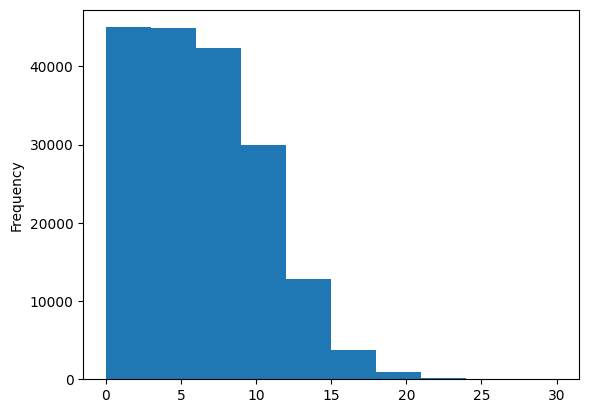

In [86]:
#Check the distribution
train_df.line_number.plot.hist()

In [87]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

In [88]:

# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [89]:

# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

In [90]:

# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

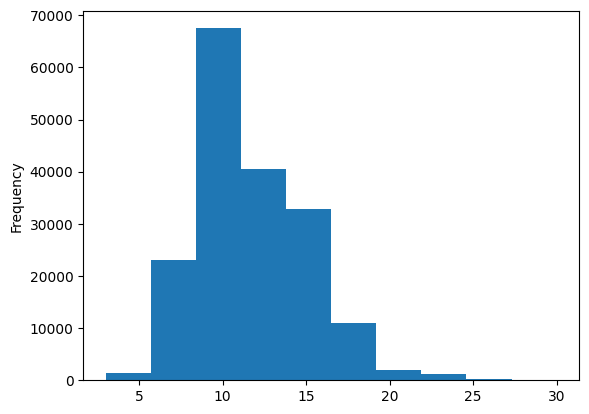

In [91]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [92]:
#Check the coverage of a "total_lines values of 30"
np.percentile(train_df.total_lines,98)

20.0

In [93]:
 #Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
 train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
 val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
 test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

In [94]:
# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

#Building a tribrid embedding model

Create a token-level model (similar to model_1)

Create a character-level model (similar to model_3 with a slight modification to reflect the paper)

Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)

Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)

Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts

Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
Create an output layer to accept the tribrid embedding and output predicted label probabilities

Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [95]:
# 1. Token inputs
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_inputs")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

#2 Char inputs
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embedings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(32))(char_embedings)
char_model=tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)
#3 Line number inputs
line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
x=layers.Dense(32,activation='relu')(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,
                                  outputs=x)

#4 Total line inputs
total_line_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_line_input")
y=layers.Dense(32,activation='relu')(total_line_inputs)
total_line_model=tf.keras.Model(inputs=total_line_inputs,
                                  outputs=y)

#5 Combine token and char embeddings into a hybrid embedding
combined_embedings=layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
z=layers.Dense(256,activation="relu")(combined_embedings)
z=layers.Dropout(0.5)(z)

#6 Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z=layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                              total_line_model.output,
                                                              z])
#7 Create output layer
output_layer=layers.Dense(5,activation="softmax", name="output_layer")(z)

#8 Create the model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

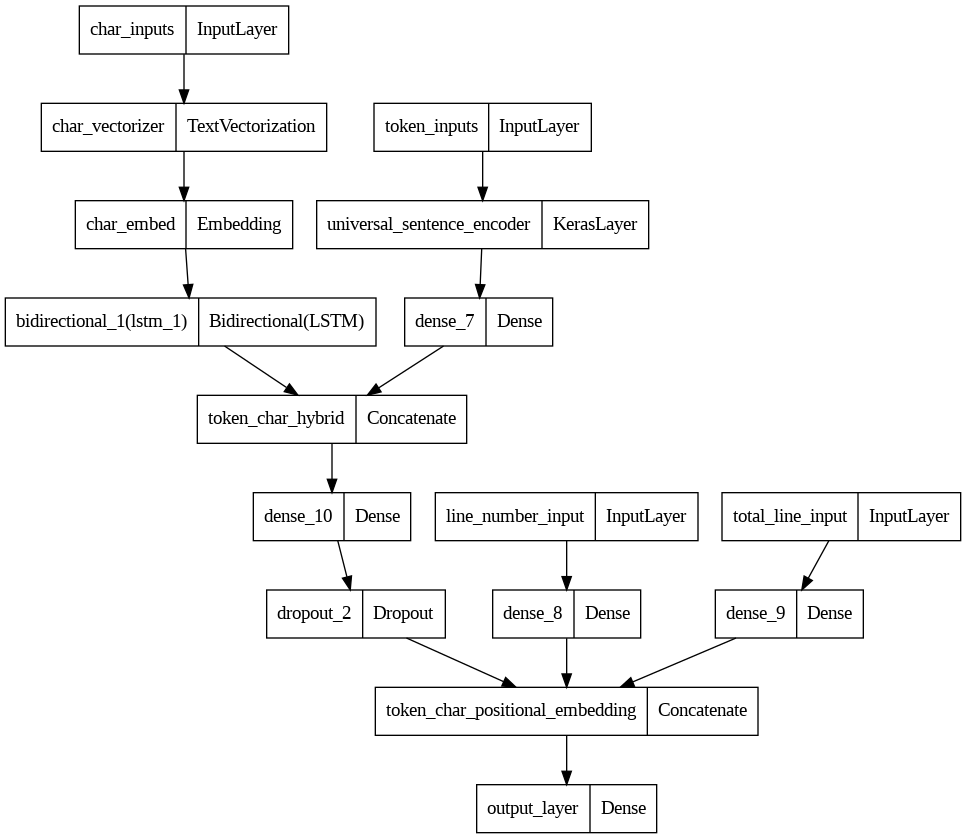

In [96]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [97]:
#Compile teh model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [98]:
#Create training and validation datasets(all four kinds of inputs)
train_pos_char_token_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                              train_total_lines_one_hot,
                                                              train_sentences,
                                                              train_chars))
train_pos_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset=tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_labels))
train_pos_char_token_dataset=train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot_encoded)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [99]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 29s 42ms/step - loss: 1.1067 - accuracy: 0.7176 - val_loss: 0.9883 - val_accuracy: 0.8035
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9692 - accuracy: 0.8129 - val_loss: 0.9501 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9512 - accuracy: 0.8241 - val_loss: 0.9419 - val_accuracy: 0.8265


In [100]:

# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs


945/945 [==============================] - 20s 19ms/step


array([[0.46350878, 0.13690117, 0.0128489 , 0.36739382, 0.01934724],
       [0.51926714, 0.11794224, 0.03873367, 0.31196606, 0.01209091],
       [0.25864327, 0.09618292, 0.14061926, 0.43042314, 0.07413135],
       ...,
       [0.03296024, 0.10562418, 0.04549374, 0.03162578, 0.7842961 ],
       [0.02678338, 0.2636616 , 0.06803899, 0.02527962, 0.6162364 ],
       [0.16705391, 0.6417428 , 0.08866531, 0.04191716, 0.06062086]],
      dtype=float32)

In [101]:

# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [102]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.98689262544684,
 'precision': 0.8289195024767887,
 'recall': 0.8298689262544684,
 'f1': 0.8290624252621502}

#Compare model results

In [103]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.025288,0.776100,0.780253,0.777581
pretrained_token_embed,71.203495,0.712497,0.712035,0.709148
custom_char_embed_conv1d,64.997352,0.642889,0.649974,0.640111
hybrid_char_token_embed,72.795578,0.730185,0.727956,0.724209
tribrid_pos_char_token_embed,82.986893,0.828920,0.829869,0.829062


In [104]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

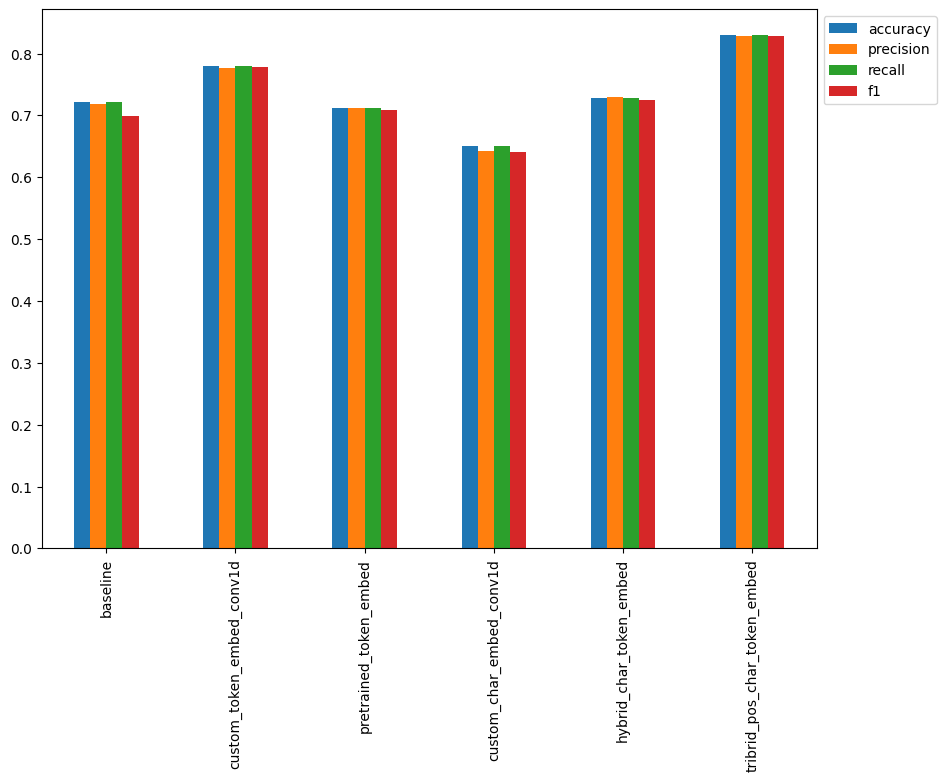

In [105]:

# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

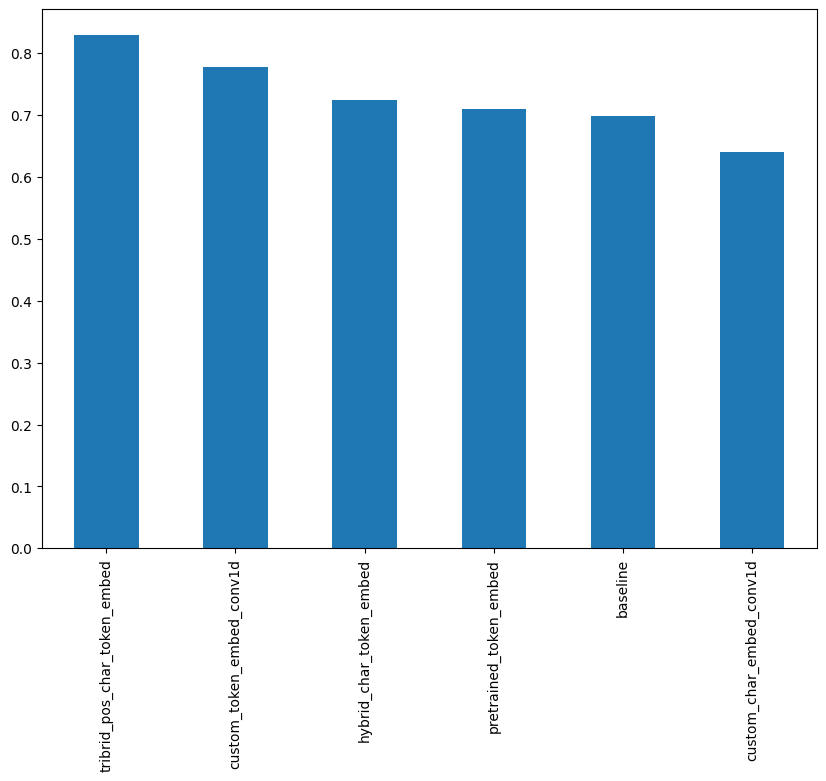

In [106]:
#sort model reslts by f1-score
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

#Save and load best performing model


In [107]:
#save the model
model_5.save("skimlit_tribrid_model")

In [108]:

# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
# !cp skimlit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit

In [109]:

# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-07-23 09:36:15--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  15.5MB/s    in 55s     

2024-07-23 09:37:11 (16.7 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/s

In [110]:
#Import Tensorflow model dependecies
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path="skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model=tf.keras.models.load_model(model_path)


#Make predictions and evalaute them against the truth labels

In [111]:
#make predictions on loadede model
loaded_pred_probs=loaded_model.predict(val_pos_char_token_dataset,verbose=1)
loaded_preds=tf.argmax(loaded_pred_probs,axis=1)
loaded_preds[:10]

945/945 [==============================] - 21s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [112]:

# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

In [113]:
#Compare loaded model with original trained model
np.isclose(list(model_5_results.values()),list(loaded_model_results.values()),rtol=1e-02),

(array([ True,  True,  True,  True]),)

In [123]:
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

#Evaluate model on test dataset

In [114]:
#Create test dataset batch and prefetched
test_poschar_token_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                            test_total_lines_one_hot,
                                                            test_sentences,
                                                            test_chars))
test_pos_char_token_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot_encoded)
test_pos_char_token_dataset=tf.data.Dataset.zip((test_poschar_token_data,test_pos_char_token_labels))
test_pos_char_token_dataset=test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Check Shape
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [115]:

# Make predictions on the test dataset
test_pred_probs=loaded_model.predict(test_pos_char_token_dataset,verbose=1)
test_preds=tf.argmax(test_pred_probs,axis=1)
test_preds[:10]

942/942 [==============================] - 20s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [116]:
#Evaluate loaded model test predictions
loaded_model_test_results=calculate_results(test_labels_encoded,test_preds)
loaded_model_test_results

{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

#Find most wrong

In [117]:
#First we'll convert all of our integer-based test predictions into their string-based class names.
# Get list of class names of test predictions
test_pred_classes=[label_encoder.classes_[i] for i in test_preds]
test_pred_classes[:10]

['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [118]:

# Create prediction-enriched test dataframe
test_df["prediction"]=test_pred_classes # create column with test prediction class names
test_df["pred_prob"]=tf.reduce_max(test_pred_probs,axis=1) # create column with test prediction probabilities
test_df["correct"]=test_df["prediction"]==test_df["target"] #create binary column for whether the prediction is right or not
test_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802459,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.881815,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.529839,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.568003,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.461431,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537819,True


In [119]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong=test_df[test_df["correct"]==False].sort_values("pred_prob",ascending=False).head(100)
top_100_wrong.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.946719,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934974,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928262,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.918880,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.916908,False
23630,RESULTS,the primary outcome was to evaluate changes in...,6,14,METHODS,0.915075,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.914345,False
16633,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,19,19,BACKGROUND,0.910313,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.906662,False


In [120]:

# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples():
  _,target,text,line_number,total_lines,prediction,pred_prob,correct=row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")


Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9467191696166992, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9349740743637085, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9309859275817871, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9282616972923279, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.918879508972168, Line number: 0, Total lines: 10

Text:
to validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the optical quality analysis system ( oqas , visiometrics , terrassa , spain ) 

#Make Example predictions

More specifically, for each abstract, we'll need to:

1.Split it into sentences (lines).

2.Split it into characters.

3.Find the number of each line.

4.Find the total number of lines.


Another more advanced option would be to leverage spaCy's (a very powerful NLP library) sentencizer class. Which is an easy to use sentence splitter based on spaCy's English language model.

In [121]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json","r") as f:
  example_abstracts=json.load(f)
example_abstracts

--2024-07-23 09:38:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-07-23 09:38:33 (73.9 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [122]:
#See how abstracts look like
abstracts=pd.DataFrame(example_abstracts)
abstracts


,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...
